In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lib
from importlib import reload
from scipy.sparse.linalg import cg

In [2]:
nside = 64
reload(lib)
P = lib.generate_pointing(nside)

nsamp = P.shape[0]
rate = 10
seconds = nsamp / rate
times = np.linspace(0, seconds, nsamp)
    
print(f'Total samples: {nsamp}')
print(f'Total time: {seconds}')

Total samples: 8192
Total time: 819.2


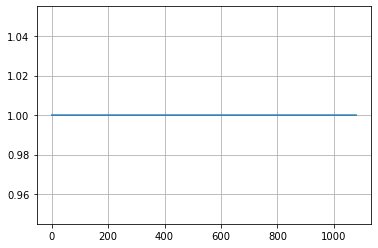

In [3]:
pix_size = 10 #arcmin
ell = np.arange(0, 180/pix_size*60)
Dl = np.ones_like(ell)
plt.plot(ell, Dl)
plt.grid()

/scratch/yuyang/destripe/lib.py:9: RuntimeWarning: divide by zero encountered in true_divide
  Cl = Dl * 2 * np.pi / (ell*(ell+1))


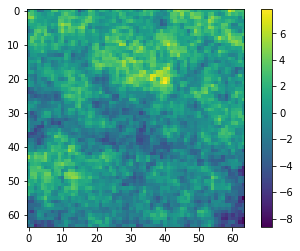

In [4]:
reload(lib)
m = lib.generate_map(Dl, nside, pix_size)
m -= np.mean(m)
plt.imshow(m)
plt.colorbar()

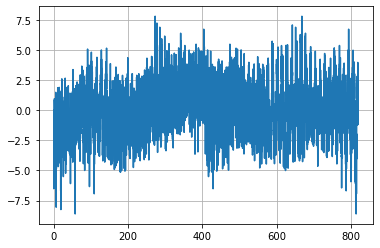

In [5]:
signal = P@m.flatten()
plt.plot(times, signal)
plt.grid()

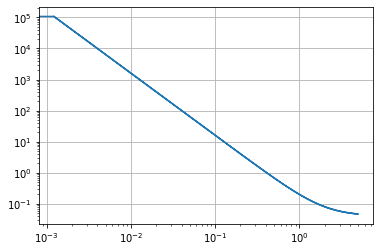

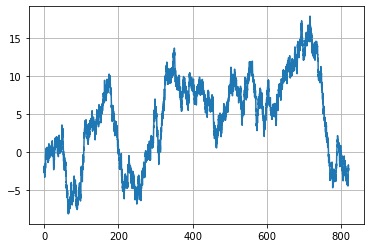

In [6]:
reload(lib)
noise = lib.generate_noise(nsamp, 1/rate, fknee=2, alpha=2, sigma=2e-1)
plt.plot(times, noise)
plt.grid()

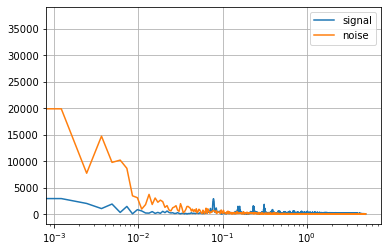

In [7]:
freqs = np.fft.rfftfreq(nsamp, 1/rate)
fft_signal = np.fft.rfft(signal)
fft_noise = np.fft.rfft(noise)
plt.plot(freqs, np.abs(fft_signal), label='signal')
plt.plot(freqs, np.abs(fft_noise), label='noise')
plt.legend()
plt.xscale('log')
# plt.yscale('log')
# plt.ylim([0, 1])
plt.grid()

In [8]:
y = signal + noise # + n

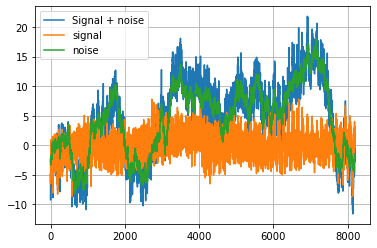

In [9]:
plt.plot(y, label='Signal + noise')
plt.plot(signal, label='signal')
plt.plot(noise, label='noise')
plt.legend()
plt.grid()

In [10]:
#Baselines matrix F
reload(lib)
baseline_length = 10 #seconds
F = lib.generate_baselines(baseline_length, nsamp, rate)

In [11]:
# destriping
Z = np.eye(nsamp) - P @ np.linalg.inv(P.T @ P) @ P.T

#Ax = b
A = F.T @ Z @ F 
b = F.T @ Z @ y

print(A.shape, np.linalg.matrix_rank(A))

# Solution for amplitudes
a = np.linalg.solve(A, b)

# a, error = cg(A, b)
# assert not error

(82, 82) 81


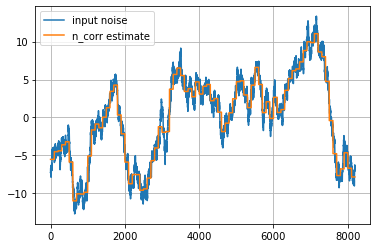

In [12]:
plt.plot(noise - np.mean(noise), label='input noise')
plt.plot(F @ a - np.mean(F@a), label='n_corr estimate')
plt.grid()
plt.legend()

In [18]:
chi2 = (y - F@a).T @ Z @ (y-F@a)
chi2

4707.288524578033

In [23]:
chi2 = (y - F@ (a+np.ones_like(a))).T @ Z @ (y-F@ (a+np.ones_like(a)))
chi2

4707.288524578033

In [13]:
m_solver = np.linalg.inv(P.T @ P) @ P.T

m_destripe = m_solver @ (y - F @ a) #Destriping solution
# m_bin = m_solver @ y #Binned map solution

#remove monopole
m_destripe -= np.mean(m_destripe)
# m_bin -= np.mean(m_bin)

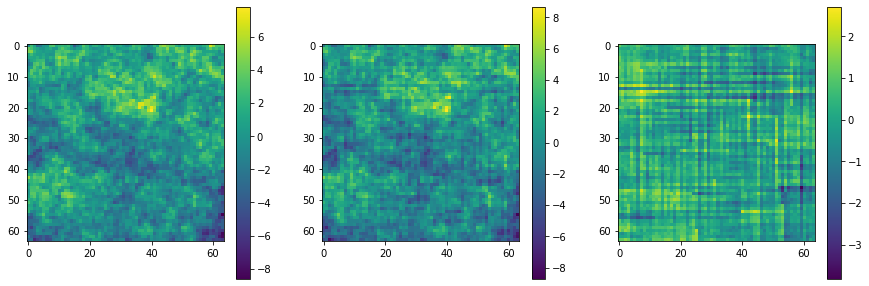

Input map std: 2.10555378136569
Solved map std: 2.2229628683074982


In [14]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))

input_map = axes[0].imshow(m)
output_map = axes[1].imshow(m_destripe.reshape(nside, nside))
diff_map = axes[2].imshow(m - m_destripe.reshape(nside, nside))

fig.colorbar(input_map, ax=axes[0])
fig.colorbar(output_map, ax=axes[1])
fig.colorbar(diff_map, ax=axes[2])

plt.show()
print(f'Input map std: {np.std(m)}')
print(f'Solved map std: {np.std(m_destripe)}')